In [1]:
import requests
import pickle
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Make a request to the Open-Metro API
response = requests.get('https://api.open-meteo.com/v1/forecast?latitude=23.71&longitude=90.41&hourly=temperature_2m&past_days=7&forecast_days=0&timezone=Asia%2FSingapore')

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    temp = data['hourly']['temperature_2m']

    date = data['hourly']['time']
    
    # Convert the data into a DataFrame
    df = pd.DataFrame({'Hourly': date, 'Temp' : temp})
    
else:
    print('Error:', response.status_code)

In [3]:
df['Hourly'] = pd.to_datetime(df['Hourly'])

The graph below seems to be stationary for the last 7 days. ARMA models are the most effective in predicting the temperature of the next 5-7 days.

<Axes: xlabel='Hourly', ylabel='Temp'>

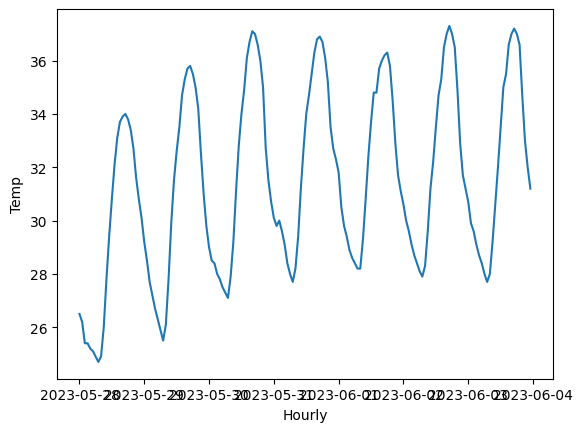

In [4]:
sns.lineplot(x='Hourly', y='Temp', data=df)

To test if the data is properly used for Augmented Dickey Fuller Test to understand if the data is stationary or non-stationary

H_0 (Null Hypothesis): alpha = 1, which means the data present is non-stationary

H_1 (Alternate Hypothesis): alpha != 1, which means the data present is be stationary meaning the data does not change over time.

In [5]:
result = adfuller(temp, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'  {key}, {value}')

ADF Statistic: -7.399991508481902
n_lags: 7.599605314464028e-11
p-value: 7.599605314464028e-11
Critial Values:
  1%, -3.471633386932248
Critial Values:
  5%, -2.8796651107461972
Critial Values:
  10%, -2.576433647235832


Given that the the p-value < 0.05, we need to reject to null-hypothesis. So, the data is in-fact stationary. Also, the ADF statistic less is compared to 1%, 5%, 10% significance levels.

Now, we need to determine to determine the auto-correlation (ACF) and partial auto-correlation (PACF) to determine the lag value to be used in the ARMA model

In [6]:
acf = sm.tsa.stattools.acf(temp, nlags=40)
pacf = sm.tsa.stattools.pacf(temp, nlags=40)

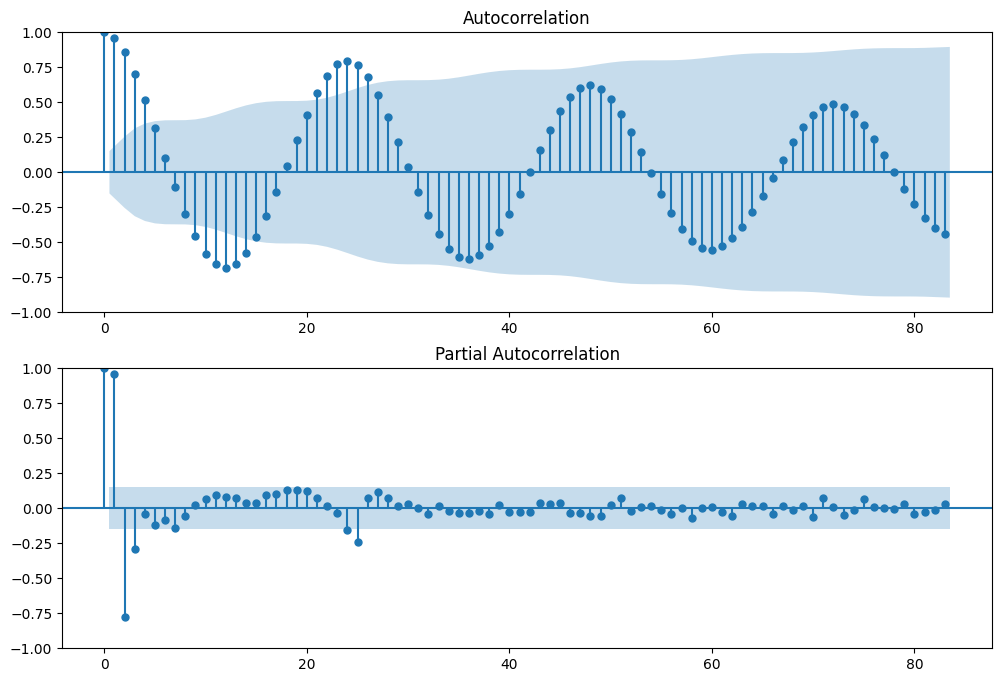

In [7]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp, lags=83, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp, lags=83, ax=ax2)

According to the Autocorrelation graph,  it suggests the presence of both seasonality and a decaying autocorrelation pattern as it suggests periodicity and gradual decrease

AR Component (p): The sine-like ACF pattern suggests the presence of seasonality. Since the ACF gradually decreases, it indicates a non-seasonal decay in autocorrelation. Considering the significant drop in the PACF at lag 3, it is best to add 3 as an AR term. However, since the ACF gradually decreases, there migh not be any need of additional AR terms. A lower value for the AR component, such as 1 or 2, can be used to evaluate the model's performance.

MA Component (q): Since the ACF gradually decreases, it suggests a non-seasonal decay in autocorrelation. If the PACF drops at lag 3 and there are no significant spikes in the ACF beyond lag 3, you might consider including lag 3 as an MA term. However, since the ACF gradually decreases, there is no need for many additional MA terms. Starting with a lower value for the MA component, such as 1 or 2, would be reasonable.

In [8]:
# Split the data into training, validation, and testing sets
train_size = int(len(temp) * 0.6)
val_size = int(len(temp) * 0.2)
test_size = len(temp) - train_size - val_size

train_data = temp[:train_size]
val_data = temp[train_size:train_size+val_size]
test_data = temp[train_size+val_size:]

In [9]:
len(train_data)

100

In [10]:
len(val_data)

33

In [11]:
len(test_data)

35

# Training and validation

## Model 1 p = 1 and q = 2

In [12]:
arma_temp_mod1 = ARIMA(train_data, order=(1, 0, 2)).fit()

print(arma_temp_mod1.params)

[30.16396064  0.93630186  1.15298215  0.61655248  0.21817997]


In [13]:
print(arma_temp_mod1.aic, arma_temp_mod1.bic, arma_temp_mod1.hqic)

147.23363485595453 160.25948578589498 152.50543111403354


In [14]:
val_predictions = arma_temp_mod1.predict(start=len(train_data), end=len(train_data)+len(val_data)-1)

# Evaluate the model on the validation data
val_mse = mean_squared_error(val_data, val_predictions)

val_mas = mean_absolute_error(val_data, val_predictions)


print("Validation MSE: ", val_mse)
print("Validation MAE: ", val_mas)

Validation MSE:  10.795915917406282
Validation MAE:  2.5142773551184825


## Model 2 p = 2 and q = 2

In [15]:
arma_temp_mod2 = ARIMA(train_data, order=(2, 0, 2)).fit()

print(arma_temp_mod2.params)

[ 3.09241499e+01  1.82811879e+00 -8.91667613e-01  5.88155503e-02
 -2.02170609e-02  1.48336984e-01]


In [16]:
print(arma_temp_mod2.aic, arma_temp_mod2.bic, arma_temp_mod2.hqic)

111.00430230230127 126.63532341822982 117.33045781199608


In [17]:
val_predictions = arma_temp_mod2.predict(start=len(train_data), end=len(train_data)+len(val_data)-1)

# Evaluate the model on the validation data
val_mse = mean_squared_error(val_data, val_predictions)

val_mas = mean_absolute_error(val_data, val_predictions)


print("Validation MSE: ", val_mse)
print("Validation MAE: ", val_mas)

Validation MSE:  5.467267430132739
Validation MAE:  1.9095200067451947


## Model 3 p = 2 and q = 1

In [18]:
arma_temp_mod3 = ARIMA(train_data, order=(2, 0, 1)).fit()

print(arma_temp_mod2.params)

[ 3.09241499e+01  1.82811879e+00 -8.91667613e-01  5.88155503e-02
 -2.02170609e-02  1.48336984e-01]


In [19]:
print(arma_temp_mod3.aic, arma_temp_mod3.bic, arma_temp_mod3.hqic)

109.02738628094944 122.0532372108899 114.29918253902845


In [20]:
val_predictions = arma_temp_mod3.predict(start=len(train_data), end=len(train_data)+len(val_data)-1)

# Evaluate the model on the validation data
val_mse = mean_squared_error(val_data, val_predictions)

val_mas = mean_absolute_error(val_data, val_predictions)


print("Validation MSE: ", val_mse)
print("Validation MAE: ", val_mas)

Validation MSE:  5.567878146930653
Validation MAE:  1.9284742119184919


As the requirement mentioned about a simple model, the BIC needs to be taken into consideration. The most optimal with fewer parameters would be the Model 4. This is the most optimal according to the analysis.

## Model 2 Summary

In [21]:
sm.stats.durbin_watson(arma_temp_mod3.resid)
#The residual values are positively correlated. The model might need to be revised. However, it is very close to value 2. So, we will keep the model 4

1.2997446423801384

In [22]:
arma_temp_mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -49.514
Date:                Sun, 04 Jun 2023   AIC                            109.027
Time:                        16:55:22   BIC                            122.053
Sample:                             0   HQIC                           114.299
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.9191      0.689     44.880      0.000      29.569      32.269
ar.L1          1.8218      0.070     26.068      0.000       1.685       1.959
ar.L2         -0.8858      0.067    -13.227      0.000      -1.017      -0.755
ma.L1          0.0736      0.140      0.526      0.599      -0.201       0.348
sigma2         0.1484      0.021      7.145      0.000       0.108       0.189
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.92   Prob(JB):                         0.63
Heteroskedasticity (H):               1.85   Skew:                             0.07
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Testing

In [23]:
predicted_temp = arma_temp_mod3.predict(start=len(test_data), end=len(test_data)+len(test_data)-1)

test_mse = mean_squared_error(test_data, predicted_temp)

test_mas = mean_absolute_error(test_data, predicted_temp)


print("Testing MSE: ", test_mse)
print("Testing MAE: ", test_mas)

Testing MSE:  3.713006239253514
Testing MAE:  1.586737300994447


The testing MSE and MAE score is very close to MSE and MAE values of the validation dataset. So, the dataset is not overfitting

# Saving the model as a pickel file for later usage

In [24]:
arma_temp_mod3.forecast(steps = 24)

array([29.1511454 , 29.04377923, 29.06860736, 29.20894326, 29.44261939,
       29.74403092, 30.08616573, 30.44249265, 30.78860317, 31.10353003,
       31.37069497, 31.57846767, 31.72034441, 31.79477841, 31.80471259,
       31.75687859, 31.66093352, 31.52850826, 31.37223819, 31.20484043,
       31.03829123, 30.88314467, 30.74802019, 30.6392723 ])

In [25]:
filename = 'TemperatureForecast.pkl'
with open(filename, 'wb') as f:
    pickle.dump(arma_temp_mod3, f)

In [26]:
filename = 'TemperatureForecast.pkl'

with open(filename, 'rb') as f:
    weatherForecaster = pickle.load(f)

In [27]:
weatherForecaster.forecast(steps = 24)

array([29.1511454 , 29.04377923, 29.06860736, 29.20894326, 29.44261939,
       29.74403092, 30.08616573, 30.44249265, 30.78860317, 31.10353003,
       31.37069497, 31.57846767, 31.72034441, 31.79477841, 31.80471259,
       31.75687859, 31.66093352, 31.52850826, 31.37223819, 31.20484043,
       31.03829123, 30.88314467, 30.74802019, 30.6392723 ])